# Testing regression model

In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import DataLoader
from models.utils import identify_device
from models.regression_utils import test_regression_model, load_regression_dataset, print_metrics_table, denormalize_material_params, normalize_material_params
from models.Regression_models import CNN1D_Regressor
from models.utils import display_model
from torch.nn import MSELoss

In [2]:
device = torch.device('cpu')
model = CNN1D_Regressor()
trained_model_name = 'regression_model_train_on_0k_clean_lr0_001_epochs_200'
unseen_dataset_name = 'unseen_3_layer_nonoise_n1to8'
training_dataset = 'train_3_layer_nonoise_n1to8'


dataset = load_regression_dataset(f'regression_data/{unseen_dataset_name}.pt') # loads data and normalizes targets in dataset
unseen_loader = DataLoader(dataset, batch_size=1024)

model.load_state_dict(torch.load(f'trained_models/{trained_model_name}.pth', map_location=torch.device('cpu')))
model.to(device)

display_model(model, device=device)

Loading data from regression_data/unseen_3_layer_nonoise_n1to8.pt
Dataset loaded successfully!
Number of samples: 5000
Shape of input pulse: torch.Size([1, 1024]), target vector: torch.Size([9])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1             [-1, 64, 1024]             384
         GroupNorm-2             [-1, 64, 1024]             128
         MaxPool1d-3              [-1, 64, 512]               0
            Conv1d-4             [-1, 128, 512]          41,088
         GroupNorm-5             [-1, 128, 512]             256
         MaxPool1d-6             [-1, 128, 256]               0
            Conv1d-7             [-1, 256, 256]          98,560
         GroupNorm-8             [-1, 256, 256]             512
         MaxPool1d-9             [-1, 256, 128]               0
           Conv1d-10             [-1, 256, 128]         196,864
        GroupNorm-11             [-1

In [3]:
metrics, results = test_regression_model(model, unseen_loader, device)
print_metrics_table(metrics, num_layers=3)


=== Scaled-domain metrics ===
| Param   |   RMSE |    MAE |     R² |
|---------|--------|--------|--------|
| n1      | 0.2232 | 0.1813 | 0.3757 |
| k1      | 0.2626 | 0.2207 | 0.1788 |
| d1      | 0.2624 | 0.2192 | 0.1788 |
| n2      | 0.1752 | 0.1345 | 0.622  |
| k2      | 0.2591 | 0.2182 | 0.1905 |
| d2      | 0.2679 | 0.225  | 0.1289 |
| n3      | 0.2281 | 0.1823 | 0.3735 |
| k3      | 0.2638 | 0.2222 | 0.1711 |
| d3      | 0.2598 | 0.2191 | 0.1949 |
| Mean    | 0.2447 | 0.2025 | 0.2682 |

=== Unscaled-domain metrics ===
| Param   |   RMSE |    MAE |     R² |   NRMSE |   MaxErr |   P95Err |
|---------|--------|--------|--------|---------|----------|----------|
| n1      | 1.5624 | 1.2692 | 0.3757 |  0.2232 |   5.0465 |   2.9903 |
| k1      | 0.0265 | 0.0223 | 0.1788 |  0.2626 |   0.0689 |   0.0479 |
| d1      | 0.0001 | 0.0001 | 0.1788 |  0.2624 |   0.0003 |   0.0002 |
| n2      | 1.2261 | 0.9413 | 0.622  |  0.1752 |   5.1375 |   2.5431 |
| k2      | 0.0262 | 0.022  | 0.1905 |  0.

In [4]:
index = 1
test_example_pulse = dataset[index][0]
test_example_true_vals = dataset[index][1]


print(denormalize_material_params(test_example_true_vals))

model.eval()
with torch.no_grad():
    pulse = test_example_pulse.unsqueeze(0).to(device)  # adjust based on original shape
    pred = model(pulse)
    pred = pred[0]
print(test_example_true_vals)
print(pred)

tensor([ 3.3356e+00, -2.9289e-02,  4.4947e-04,  3.1513e+00, -6.7920e-02,
         8.2824e-05,  7.5015e+00,  2.8881e-04,  2.2541e-04])
tensor([0.3337, 0.7001, 0.8877, 0.3073, 0.3176, 0.0729, 0.9288, 0.9930, 0.3898])
tensor([0.7153, 0.7889, 0.4360, 0.4845, 0.7466, 0.3901, 0.6703, 0.7800, 0.4114])


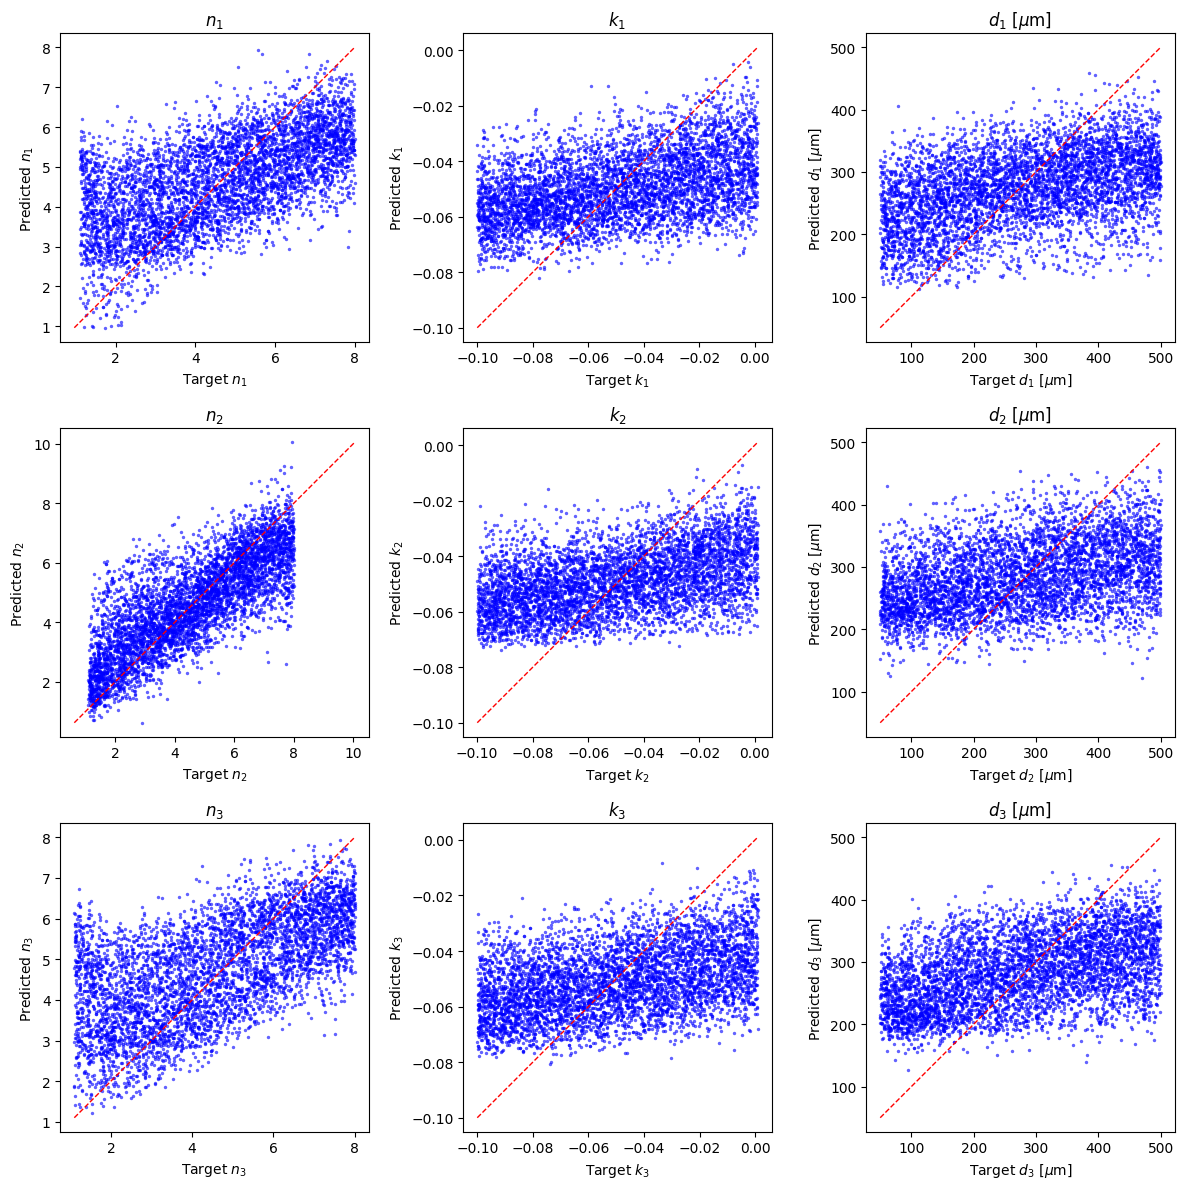

In [5]:
# Which to plot: change keys here
preds = results['preds_unscaled'].clone()
targets = results['targets_unscaled'].clone()

# Parameter labels and types
param_labels = [
    r"$n_1$", r"$k_1$", r"$d_1$ [$\mu$m]",
    r"$n_2$", r"$k_2$", r"$d_2$ [$\mu$m]",
    r"$n_3$", r"$k_3$", r"$d_3$ [$\mu$m]"
]
thickness_indices = [2, 5, 8]  # positions of d1, d2, d3

# Convert thickness values from m → μm for plotting
preds_plot = preds.clone()
targets_plot = targets.clone()
preds_plot[:, thickness_indices] *= 1e6
targets_plot[:, thickness_indices] *= 1e6

# Create figure
fig, axes = plt.subplots(3, 3, figsize=(12, 12))
axes = axes.flatten()

for i in range(9):
    ax = axes[i]
    sns.scatterplot(
        x=targets_plot[:, i],
        y=preds_plot[:, i],
        ax=ax,
        s=5, color='blue', alpha=0.6, edgecolor=None
    )

    # Add 45° perfect prediction line
    min_val = min(targets_plot[:, i].min(), preds_plot[:, i].min())
    max_val = max(targets_plot[:, i].max(), preds_plot[:, i].max())
    ax.plot([min_val, max_val], [min_val, max_val], 'r--', lw=1)

    ax.set_xlabel(f"Target {param_labels[i]}")
    ax.set_ylabel(f"Predicted {param_labels[i]}")
    ax.set_title(param_labels[i])
    ax.set_aspect('equal', adjustable='box')

plt.tight_layout()
plt.show()